In [1]:
import numpy as np
from scipy import ndimage
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [57]:
def gaussian_kernel(size, sigma=10):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [3]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [4]:
def visualize(img,dst):
    plt.subplot(121),plt.imshow(img),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(dst,cmap="gray"),plt.title('Blurred')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [58]:
def Canny_detector(img):
    weak_th = None 
    strong_th = None
    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
    # Noise reduction step
    g=gaussian_kernel(5,1)
    
    img= cv2.filter2D(src=img, kernel=g, ddepth=30)

    mag,ang=sobel_filters(img)
       
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
    print(strong_th,weak_th)
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
       
       
    # finally returning the magnitude of
    # gradients of edges
    return mag


[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]
127.5 25.5


<Figure size 1440x720 with 0 Axes>

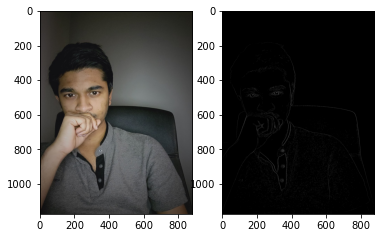

In [59]:
frame = cv2.imread('img3.jpg')
  
# calling the designed function for
# finding edges
canny_img = Canny_detector(frame)
   
# Displaying the input and output image  
plt.figure(figsize=(20,10)) 
f, plots = plt.subplots(1, 2) 
plots[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plots[1].imshow(canny_img,cmap='gray')

In [56]:
cv2.imwrite("canny_img.jpg",canny_img)

True

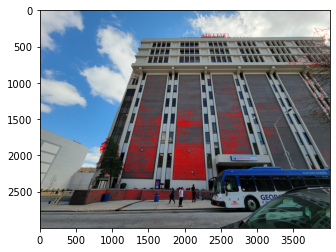

In [18]:
image = frame
 
# convert the input image into
# grayscale color space
operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# modify the data type
# setting to 32-bit floating point
operatedImage = np.float32(operatedImage)
 
# apply the cv2.cornerHarris method
# to detect the corners with appropriate
# values as input parameters
dest = cv2.cornerHarris(operatedImage, 2, 3, 0.07)
 
# Results are marked through the dilated corners
dest = cv2.dilate(dest, None)
 
# Reverting back to the original image,
# with optimal threshold value
image[dest > 0.01 * dest.max()]=[0, 0, 255]
 
# the window showing output image with corners
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
# De-allocate any associated memory usage
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

In [19]:
cv2.imwrite("corner_image.jpg",image)

True

In [20]:
canny_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])